In [2]:
import pandas as pd
import numpy as np
import sympy
import datetime as dt
import time
from math import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from ipyleaflet import *
import folium
import json
import geopy.distance
from haversine import haversine
from tqdm import tqdm_notebook

sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

In [4]:
taxi = pd.read_csv("train.csv") # 각자 데이터셋의 폴더

FileNotFoundError: File b'train.csv' does not exist

### data에 대한 기본적인 탐색

- traing data의 row 수와 column 수

In [4]:
print("traing data의 row 수 : {}, column 수 : {}".format(taxi.shape[0], taxi.shape[1]))

traing data의 row 수 : 1458644, column 수 : 11


In [3]:
taxi.tail()

NameError: name 'taxi' is not defined

In [7]:
taxi_describe.round(2)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


In [4]:
taxi['count'] = 1

# 전처리

- 아웃라이어 제거
1. 시간
    - pickup_datetime
2. 위치
3. 승객수

### 아웃라이어 제거
- 시간
- 승객수
- 위치

In [5]:
# 운행 시간 0, 2시간 벗어나는 데이터 제거

taxi = taxi[taxi["trip_duration"] >= 0]
taxi = taxi[taxi["trip_duration"] <= 60*60*2]

In [6]:
# 승객 수 0명 제거

taxi = taxi[taxi["passenger_count"] != 0]

## pickup_datetime 살피기

In [7]:
# pd.to_datetime을 해줘야 pickup_datetime coulmn의 data type이 datetime으로 됨
pickup_datetime_dt = pd.to_datetime(taxi["pickup_datetime"])
dropoff_datetime_dt = pd.to_datetime(taxi["dropoff_datetime"])

In [8]:
# trip_duration, count를 포함하고, pickup_datetime의 data로만 이루어진 dataframe(taxi_df1)을 만든다.
taxi_df1 = taxi.loc[:, ["passenger_count","trip_duration", "count"]]
taxi_df1["pickup_datetime"] = pickup_datetime_dt

In [9]:
# pickup datetime 중 year, month, day
taxi_df1.loc[:, "pickup_date"] = taxi_df1["pickup_datetime"].dt.date
# pickup datetime 중 month만 가져와서 새로 column을 만듦.
taxi_df1.loc[:, "pickup_month"] = taxi_df1["pickup_datetime"].dt.month
# pickup datetime 중 hour만 가져와서 새로 column을 만듦.
taxi_df1.loc[:, "pickup_hour"] = taxi_df1["pickup_datetime"].dt.hour
# pickup datetime 중 요일만 가져와서 새로 column을 만듦.
# 월요일은 0이고, 일요일은 6임.
taxi_df1.loc[:, "pickup_weekday"] = taxi_df1["pickup_datetime"].dt.weekday

In [10]:
taxi_df1.tail()

,passenger_count,trip_duration,count,pickup_datetime,pickup_date,pickup_month,pickup_hour,pickup_weekday
1458639,4,778,1,2016-04-08 13:31:04,2016-04-08,4,13,4
1458640,1,655,1,2016-01-10 07:35:15,2016-01-10,1,7,6
1458641,1,764,1,2016-04-22 06:57:41,2016-04-22,4,6,4
1458642,1,373,1,2016-01-05 15:56:26,2016-01-05,1,15,1
1458643,1,198,1,2016-04-05 14:44:25,2016-04-05,4,14,1


### 날짜 분포도

- year
- month

In [11]:
# year
print("데이터가 기록된 연도")
print("가장 오래된 데이터의 기록 연도: {}년".format(taxi_df1["pickup_datetime"].dt.year.min()))
print("가장 최신 데이터의 기록 연도: {}년".format(taxi_df1["pickup_datetime"].dt.year.max()))
print('')

# month
print("데이터가 기록된 달")
print("가장 오래된 데이터의 기록된 달: {}월".format(taxi_df1["pickup_month"].min()))
print("가장 최신 데이터가 기록된 달: {}월".format(taxi_df1["pickup_month"].max()))

데이터가 기록된 연도
가장 오래된 데이터의 기록 연도: 2016년
가장 최신 데이터의 기록 연도: 2016년

데이터가 기록된 달
가장 오래된 데이터의 기록된 달: 1월
가장 최신 데이터가 기록된 달: 6월


In [12]:
taxi_month_count = taxi_df1.loc[:, ["pickup_month", "count"]]
taxi_month_count.groupby("pickup_month").sum()

,count
pickup_month,
1,229351
2,237954
3,255772
4,251256
5,248068
6,233931


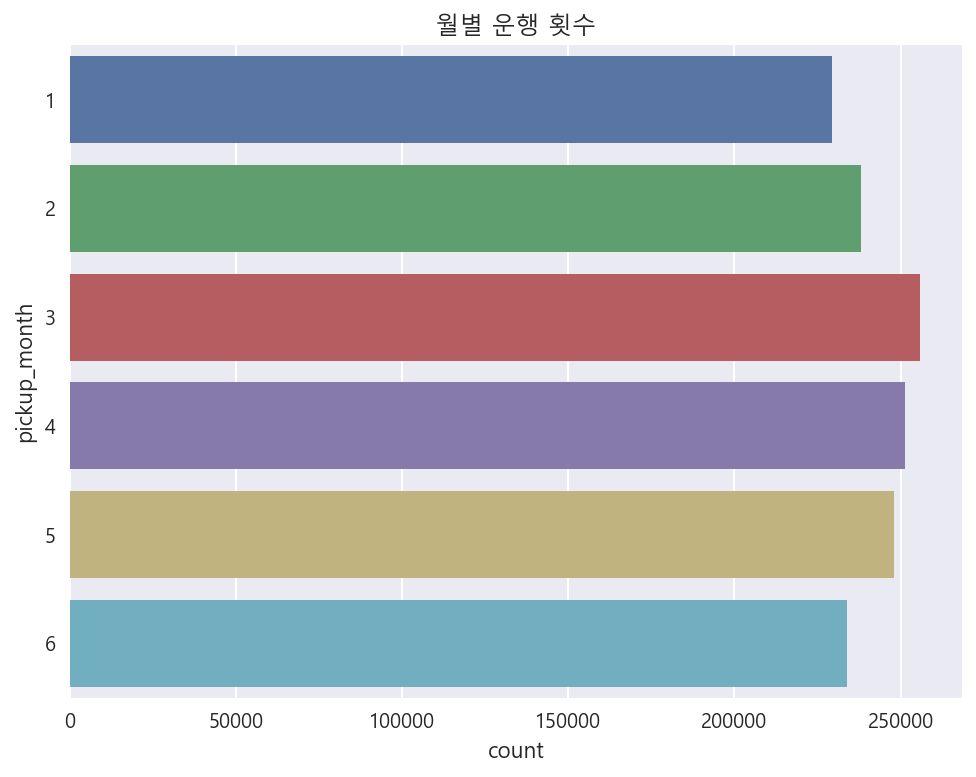

In [13]:
plt.figure(figsize=(8, 6))
plt.title("월별 운행 횟수")
sns.countplot(y='pickup_month', data=taxi_month_count);

In [14]:
taxi_month_duration = taxi_df1.loc[:, ["pickup_month", "trip_duration"]]
taxi_month_duration = taxi_month_duration.groupby("pickup_month").mean()
taxi_month_duration

,trip_duration
pickup_month,
1,790.046802
2,789.231288
3,816.782998
4,847.127014
5,881.970863
6,889.541502


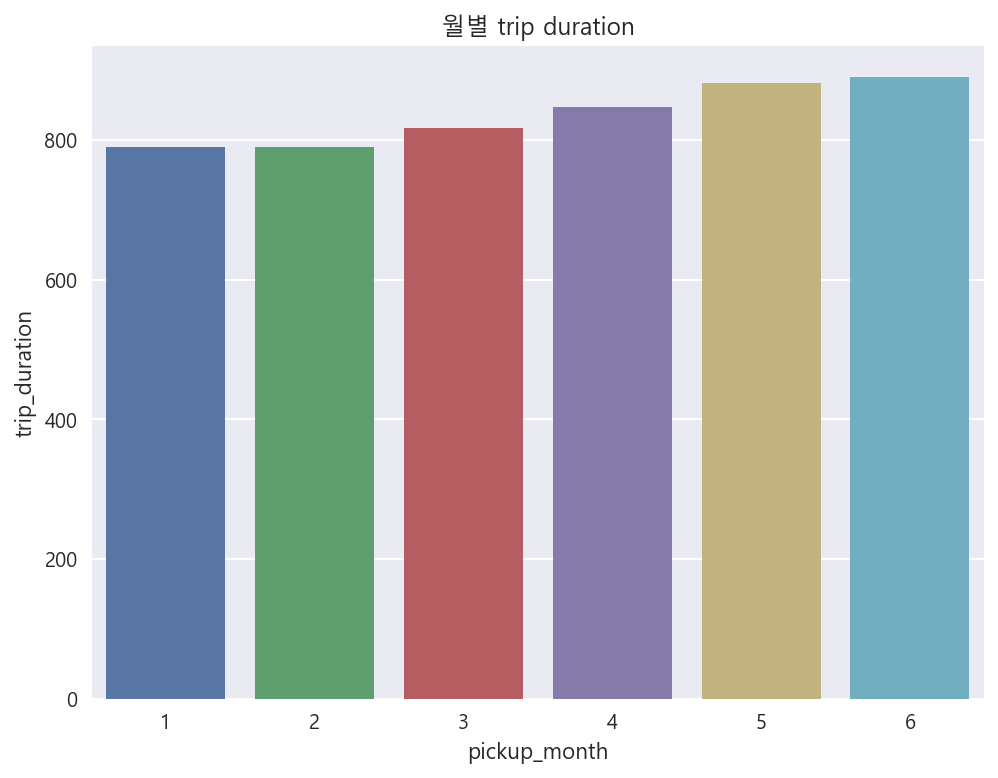

In [15]:
plt.figure(figsize=(8, 6))
plt.title("월별 trip duration")
sns.barplot(x=taxi_month_duration.index, 
            y=taxi_month_duration.trip_duration, 
            data=taxi_month_duration);

- hour 살피기

In [16]:
print("가장 이른 탑승 시각: {}시".format(taxi_df1["pickup_hour"].min()))
print("가장 늦은 탑승 시각: {}시".format(taxi_df1["pickup_hour"].max()))

가장 이른 탑승 시각: 0시
가장 늦은 탑승 시각: 23시


In [17]:
taxi_hour_count = taxi_df1.loc[:, ["pickup_hour", "count"]]
taxi_hour_count.groupby("pickup_hour").sum().tail()

,count
pickup_hour,
19,90187
20,83943
21,84056
22,80341
23,69685


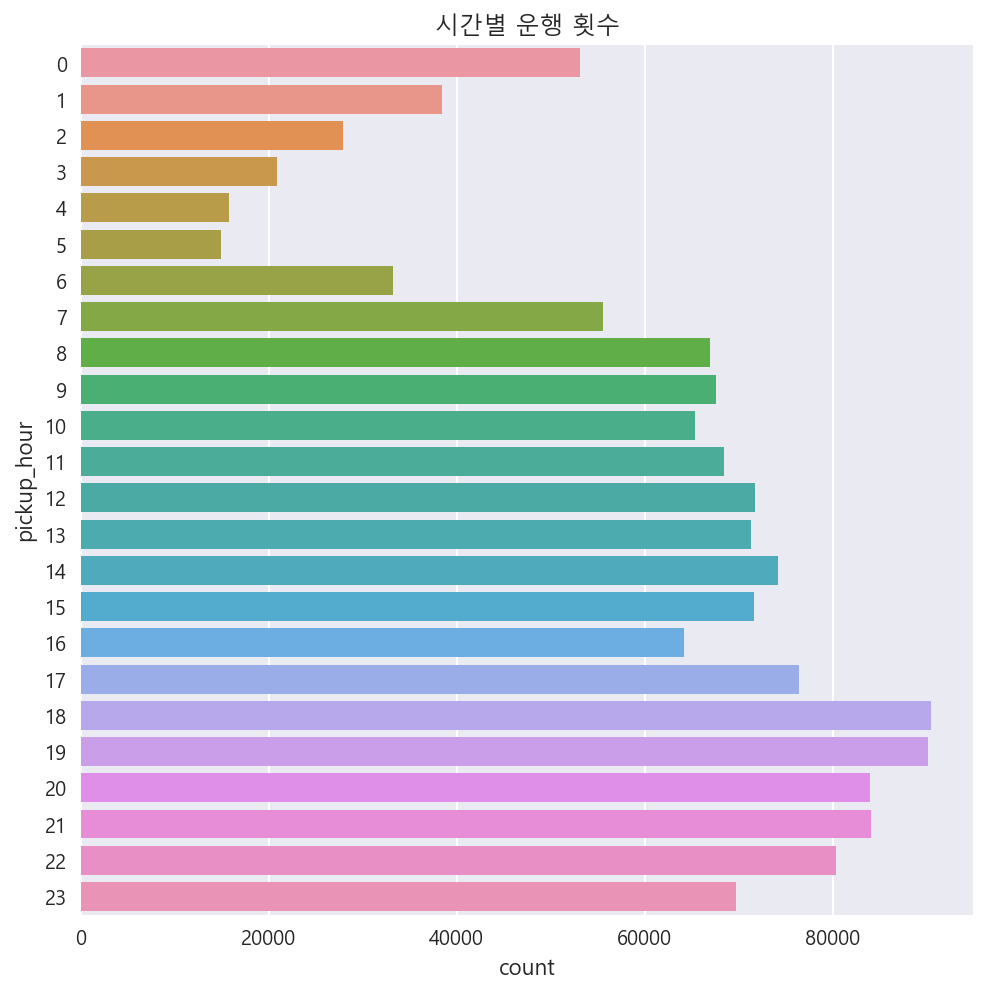

In [18]:
plt.figure(figsize=(8, 8))
plt.title("시간별 운행 횟수")
sns.countplot(y='pickup_hour', data=taxi_hour_count);

In [19]:
taxi_hour_duration = taxi_df1.loc[:, ["pickup_hour", "trip_duration"]]
taxi_hour_duration = taxi_hour_duration.groupby("pickup_hour").mean()
taxi_hour_duration.tail()

,trip_duration
pickup_hour,
19,789.673833
20,768.234659
21,775.950010
22,804.420682
23,812.118433


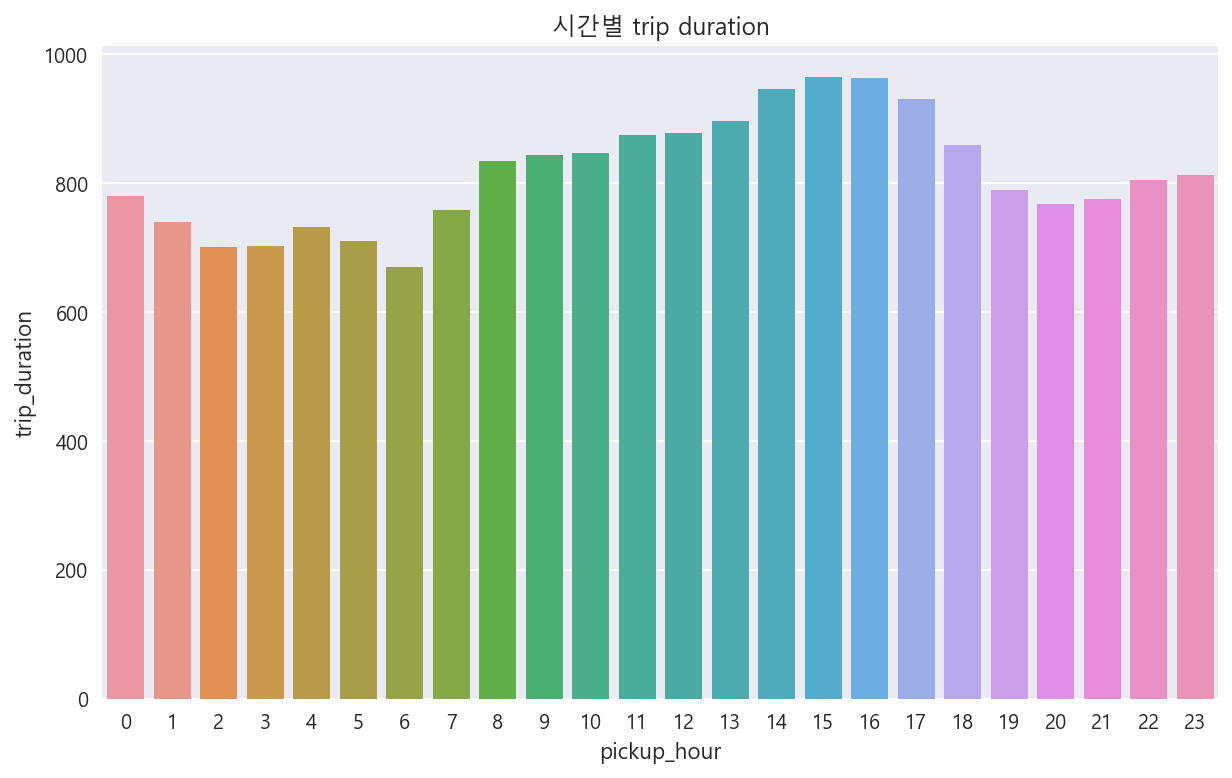

In [20]:
plt.figure(figsize=(10, 6))
plt.title("시간별 trip duration")
sns.barplot(x=taxi_hour_duration.index, 
            y=taxi_hour_duration.trip_duration,
            data=taxi_month_duration);

- 요일 살피기

In [21]:
print("기록이 시작되는 요일: {}".format(taxi_df1["pickup_weekday"].min()))
print("기록이 끝나는 요일: {}".format(taxi_df1["pickup_weekday"].max()))

기록이 시작되는 요일: 0
기록이 끝나는 요일: 6


In [22]:
taxi_weekday_count = taxi_df1.loc[:, ["pickup_weekday", "count"]]
taxi_weekday_count.groupby("pickup_weekday").sum()

,count
pickup_weekday,
0,187179
1,202449
2,209856
3,218254
4,223157
5,220443
6,194994


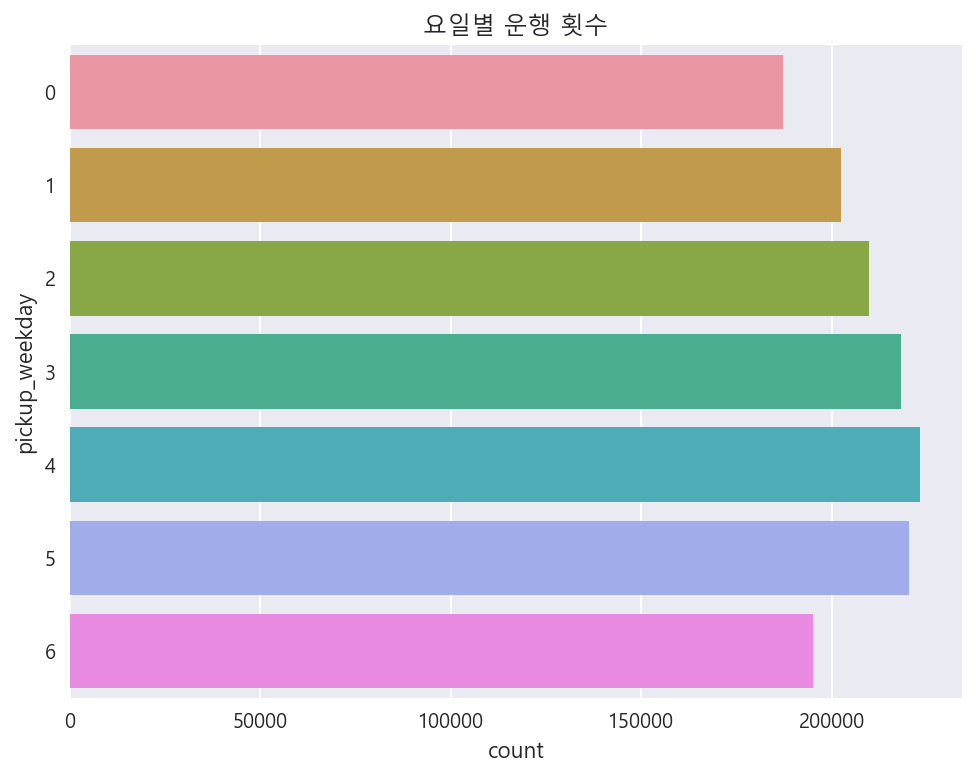

In [23]:
plt.figure(figsize=(8, 6))
plt.title("요일별 운행 횟수")
sns.countplot(y='pickup_weekday', data=taxi_weekday_count);

In [24]:
taxi_weekday_duration = taxi_df1.loc[:, ["pickup_weekday", "trip_duration"]]
taxi_weekday_duration = taxi_weekday_duration.groupby("pickup_weekday").mean()
taxi_weekday_duration

,trip_duration
pickup_weekday,
0,809.125089
1,854.351402
2,878.472433
3,896.415268
4,865.978885
5,777.759403
6,761.670646


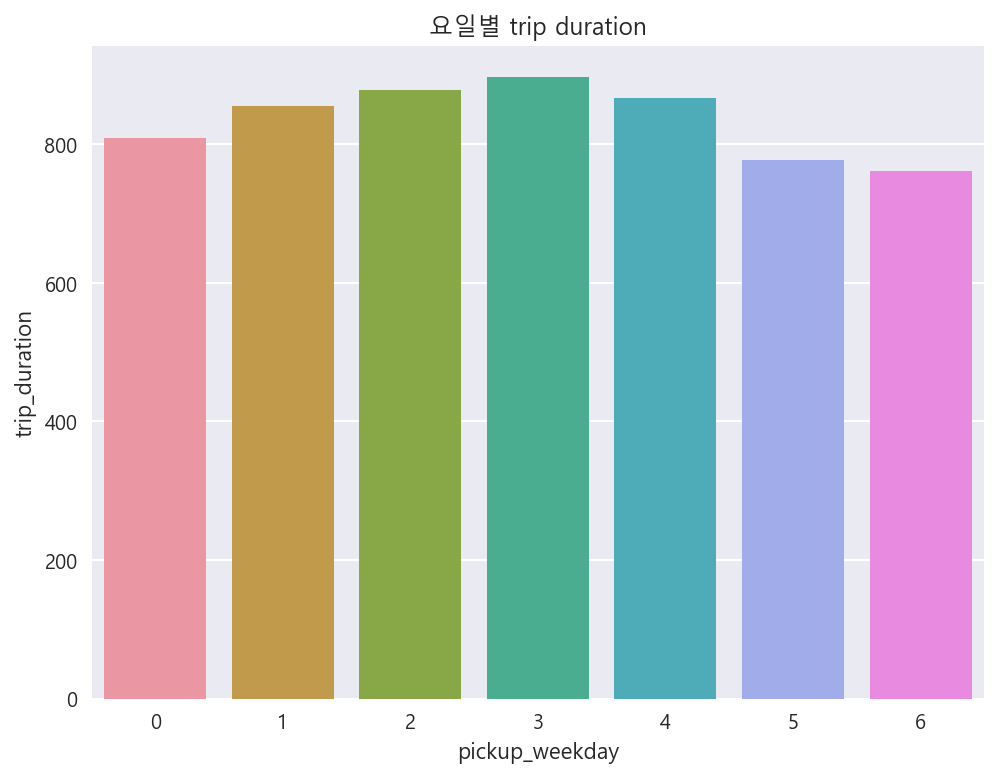

In [25]:
plt.figure(figsize=(8, 6))
plt.title("요일별 trip duration")
sns.barplot(x=taxi_weekday_duration.index, 
            y=taxi_weekday_duration.trip_duration,
            data=taxi_weekday_duration);

### EDA of pickup_datetime in train data
- year : 2016년 
- month : 1~6월
- hour : 0~23시
- weekday : 월요일~일요일

### Data Understanding

In [26]:
print('taxi : {} rows, {} columns.'.format(taxi.shape[0], taxi.shape[1]))
# print('test : {} rows, {} columns.'.format(test.shape[0], test.shape[1]))

taxi : 1456332 rows, 12 columns.


In [27]:
taxi.tail(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,count
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,1
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,1


In [28]:
# test.tail(2)   # drop-off_datetime, trip_duration excluded

### Data 뽑기 전 사전작업

In [29]:
### 승객수 / 승차시간 / 승차요일 간의 관계 파악을 위한 표 작성

taxi_df2 = pd.DataFrame(taxi_df1, columns=["passenger_count", "pickup_hour", "pickup_weekday", "trip_duration", "count"])
taxi_df2 = taxi_df1.groupby(["passenger_count", "pickup_hour", "pickup_weekday"]).size().reset_index(name='count')
taxi_df2.tail()

,passenger_count,pickup_hour,pickup_weekday,count
1008,7,10,1,1
1009,7,19,5,1
1010,7,22,6,1
1011,8,1,4,1
1012,9,8,4,1


### EDA - 승객 수  data

In [30]:
### 승객수 - Max / Min

In [31]:
print(taxi_df2["passenger_count"].min())
print(taxi_df2["passenger_count"].max())

1
9


In [32]:
### 승객수의 비중 - 승객수별 id수 구하기

In [33]:
passenger_num_1 = taxi_df2.loc[:, ["passenger_count", "count"]]
passenger_num_1.groupby("passenger_count").sum()

,count
passenger_count,
1,1032177
2,209981
3,59771
4,28343
5,77858
6,48197
7,3
8,1
9,1


In [34]:
#### 승객수와 승차시점 관계 (pickup_hour)

In [35]:
passenger_pivot1 = taxi_df2.pivot_table(values="count", index=["passenger_count"], columns=["pickup_hour"], aggfunc=np.sum)
passenger_pivot1.fillna(value=0)

pickup_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
passenger_count,,,,,,,,,,,,,,,,,,,,,
1,36297.0,26286.0,19062.0,14289.0,11045.0,11359.0,25986.0,42474.0,50372.0,50590.0,...,52247.0,50382.0,44780.0,53271.0,63631.0,63143.0,58618.0,57762.0,54496.0,47509.0
2,8795.0,6047.0,4404.0,3259.0,2192.0,1737.0,3364.0,6079.0,7570.0,7661.0,...,10667.0,10592.0,9798.0,11896.0,13473.0,13770.0,12847.0,13522.0,13497.0,11452.0
3,2378.0,1889.0,1366.0,1005.0,698.0,479.0,830.0,1633.0,2167.0,2173.0,...,3056.0,3108.0,2836.0,3410.0,3886.0,3901.0,3514.0,3762.0,3667.0,3184.0
4,1184.0,867.0,671.0,439.0,349.0,191.0,429.0,701.0,993.0,984.0,...,1518.0,1396.0,1328.0,1488.0,1782.0,1825.0,1784.0,1799.0,1823.0,1593.0
5,2938.0,2111.0,1543.0,1155.0,898.0,659.0,1527.0,2767.0,3509.0,3743.0,...,3979.0,3756.0,3287.0,3951.0,4885.0,4744.0,4599.0,4616.0,4470.0,3787.0
6,1574.0,1284.0,861.0,698.0,569.0,547.0,1080.0,1888.0,2361.0,2432.0,...,2682.0,2421.0,2167.0,2354.0,2798.0,2803.0,2581.0,2595.0,2387.0,2160.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


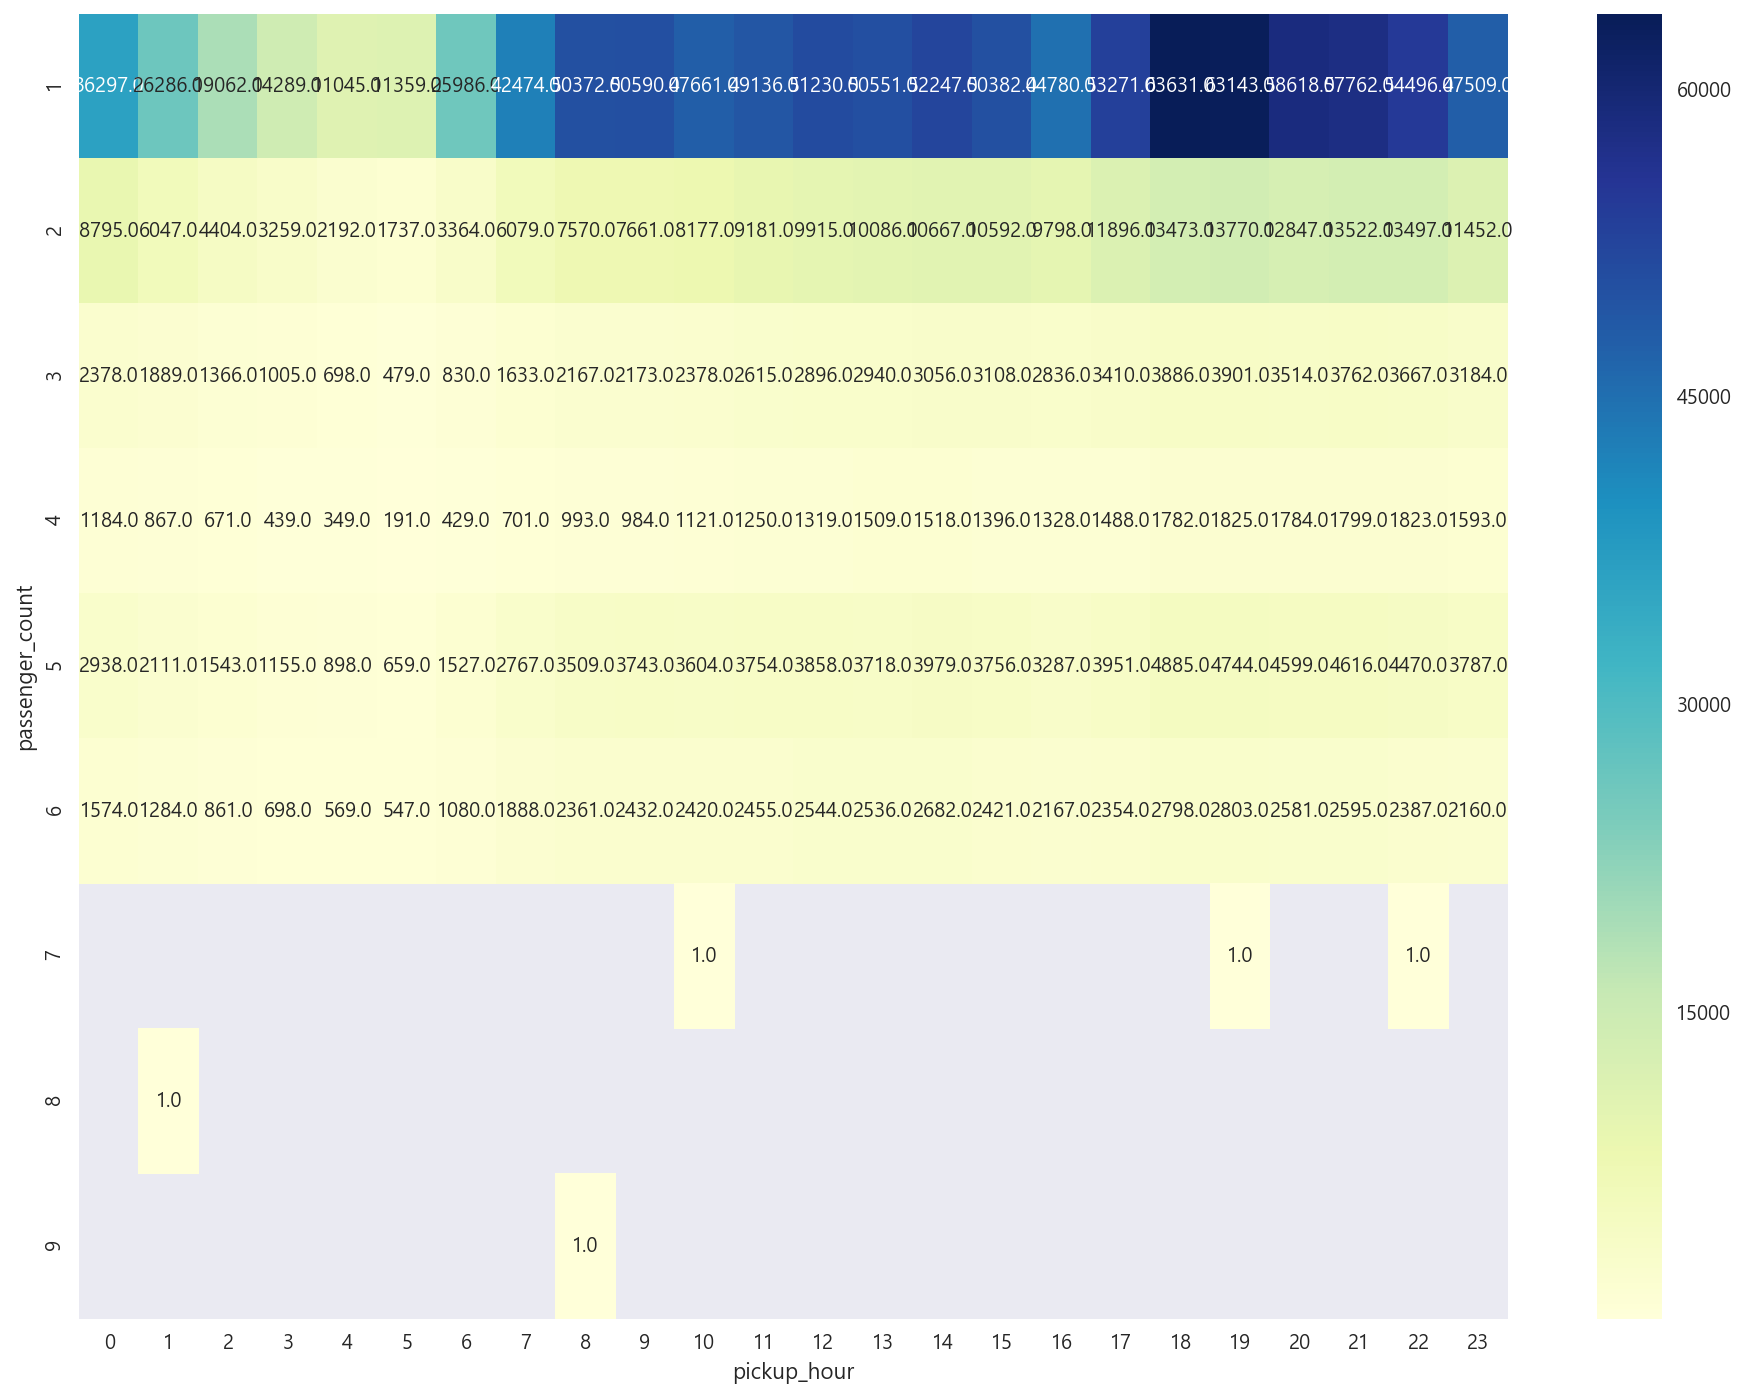

In [36]:
plt.figure(figsize=(16, 12))
sns.heatmap(passenger_pivot1, cmap="YlGnBu", annot=True, fmt=".1f")

In [37]:
#### 승객수와 승차시점 관계 (pickup_weekday)

In [38]:
passenger_pivot2 = taxi_df2.pivot_table(values="count", index=["passenger_count"], columns=["pickup_weekday"], aggfunc=np.sum)
passenger_pivot2.fillna(value=0)

pickup_weekday,0,1,2,3,4,5,6
passenger_count,,,,,,,
1,135216.0,147513.0,152867.0,158348.0,158564.0,147643.0,132026.0
2,25826.0,26555.0,27669.0,29343.0,31873.0,37031.0,31684.0
3,7262.0,7416.0,7766.0,8038.0,9067.0,10752.0,9470.0
4,3354.0,3350.0,3510.0,3613.0,4423.0,5482.0,4611.0
5,9521.0,10879.0,11187.0,11655.0,11838.0,12022.0,10756.0
6,6000.0,6735.0,6857.0,7257.0,7390.0,7512.0,6446.0
7,0.0,1.0,0.0,0.0,0.0,1.0,1.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0


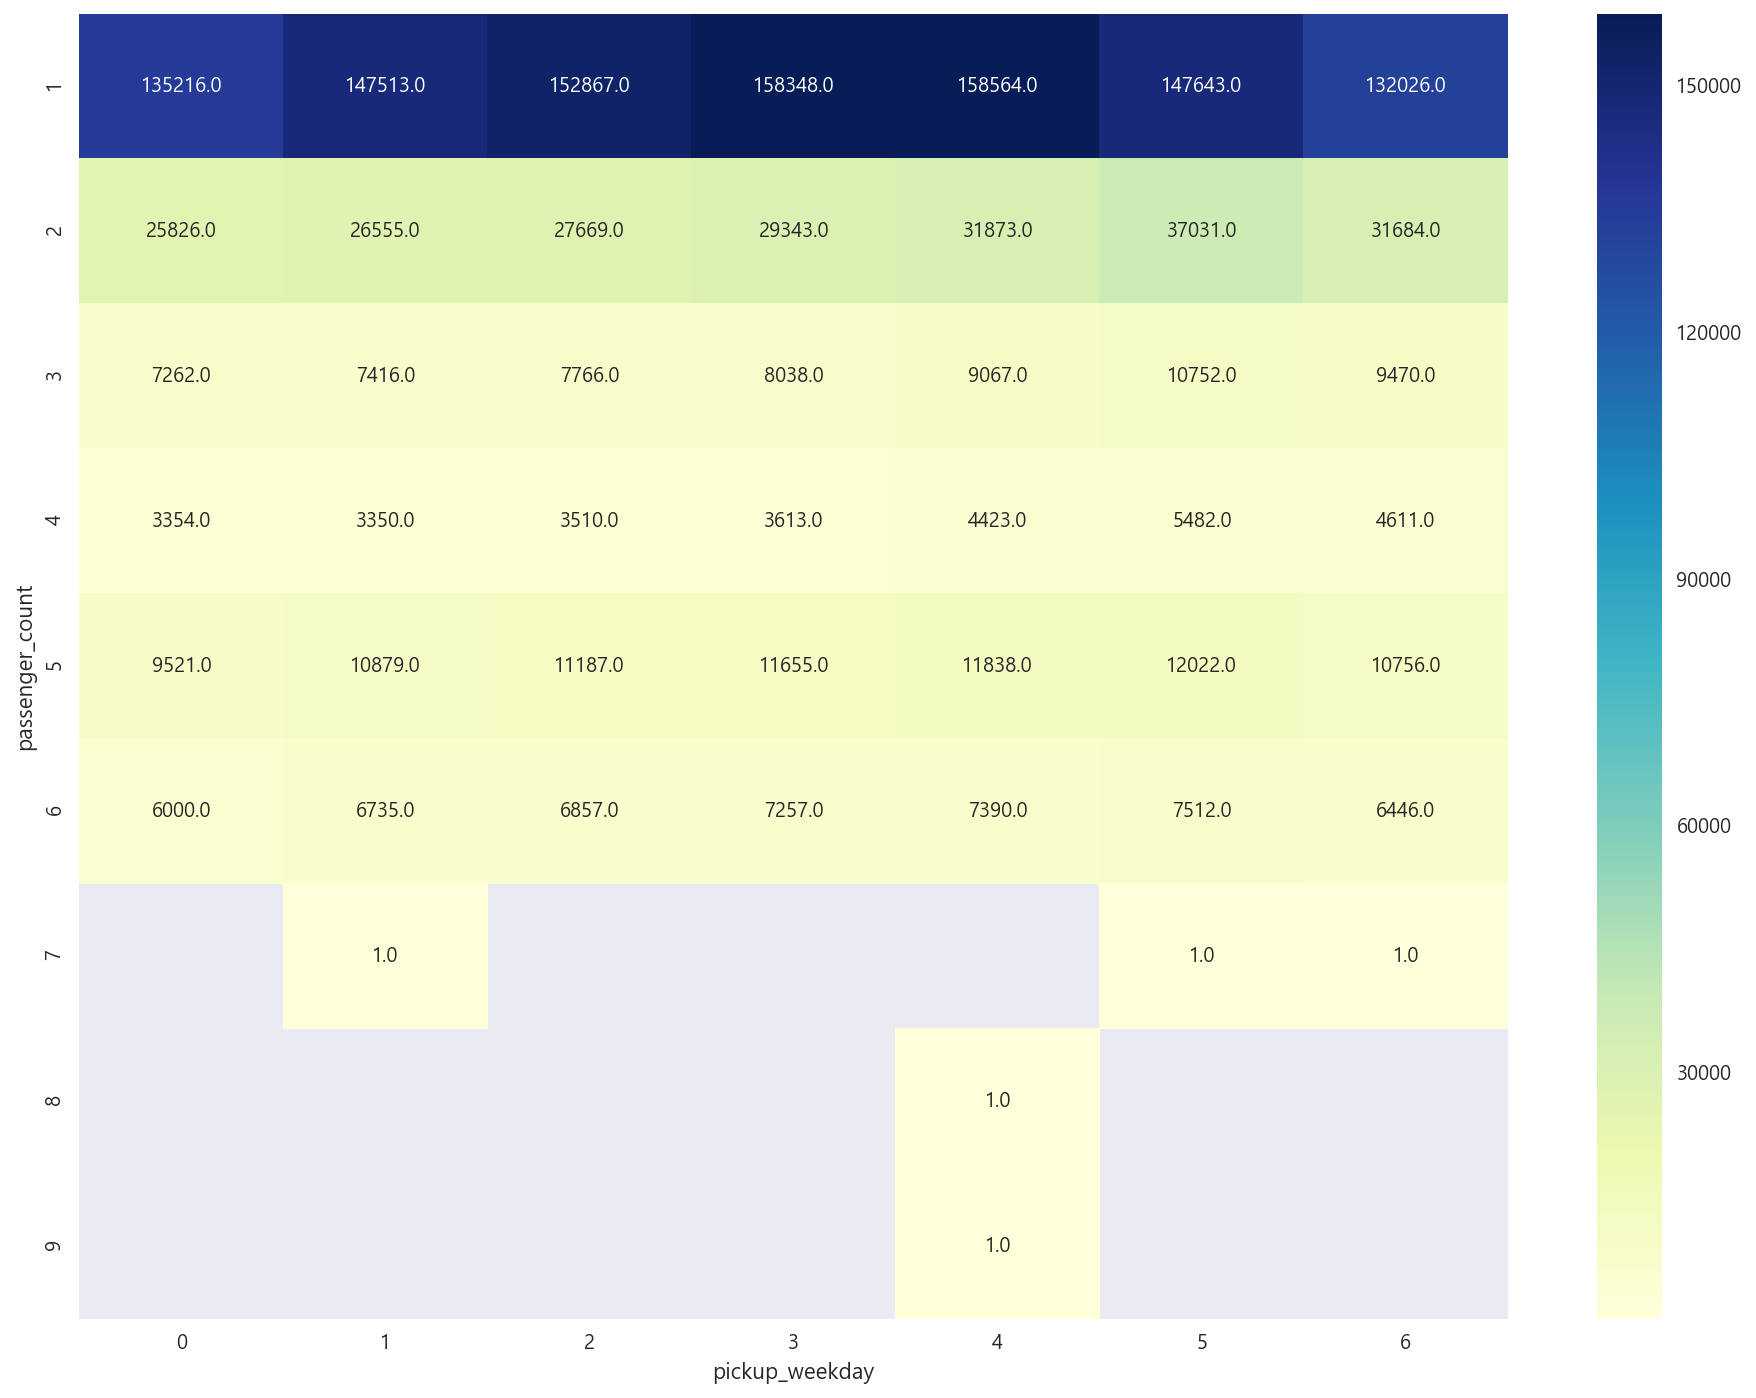

In [39]:
plt.figure(figsize=(16, 12))
sns.heatmap(passenger_pivot2, cmap="YlGnBu", annot=True, fmt="");

In [40]:
### 승객수와 운행시간 관계 (trip_duration) - 승객수가 많을 수록 duration이 길어질 것이다. (장기)

In [41]:
passenger_num_1 = taxi_df1.loc[:, ["passenger_count", "trip_duration"]]
passenger_num_1.groupby("passenger_count").mean()

,trip_duration
passenger_count,
1,824.129236
2,876.755545
3,866.650349
4,886.953498
5,843.060302
6,836.283835
7,19.666667
8,104.000000
9,560.000000


### EDA 결과
- 승객수 Max 9인, Min 0인 : 0인, 7인이상 삭제 검토 (총 65건)
- 승객수 지표 : 1인 승차객이 전체 약 146만 건 중 103만 건의 비중, 2인 승차객 21만건 / 5인 / 3인 순
- 승객수&승차시각 : 오전 8시 이후 1인 승차객 중심으로 전 시간대 고른 분포
- 승객수&승차요일 : 전반적으로 고른 분포 , 전반적으로 주말보다 수~금 승차건수가 높음
- 승객수&운행시간 : 1인 승객이 평균 1~2분정도 짧게 운행. 전반적으로 1000~1100초 (16분대), 탑승객 없는 택시 유일하게 30분 수준 (공항으로 이동?)

import folium
import json
geo_path = '../dataset/geojson/state.geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

map = folium.Map(location=[40.766321, -73.965457], zoom_start=11)

for idx, row in taxi[:150].iterrows():
    if pd.notnull(row["pickup_latitude"]):
        folium.Marker([row['pickup_latitude'], row['pickup_longitude']]).add_to(map)
        
map

In [42]:
# 뉴욕 시 경계를 벗어나는 위/경도 제거

# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85) 

taxi = taxi[taxi['pickup_longitude'] <= -73.75]
taxi = taxi[taxi['pickup_longitude'] >= -74.03]
taxi = taxi[taxi['pickup_latitude'] <= 40.85]
taxi = taxi[taxi['pickup_latitude'] >= 40.63]
taxi = taxi[taxi['dropoff_longitude'] <= -73.75]
taxi = taxi[taxi['dropoff_longitude'] >= -74.03]
taxi = taxi[taxi['dropoff_latitude'] <= 40.85]
taxi = taxi[taxi['dropoff_latitude'] >= 40.63]

In [43]:
pickup_lat = tuple(taxi["pickup_latitude"])
pickup_lng = tuple(taxi["pickup_longitude"])
dropoff_lat = tuple(taxi["dropoff_latitude"])
dropoff_lng = tuple(taxi["dropoff_longitude"])

In [44]:
pickup_loc = tuple(zip(pickup_lat, pickup_lng))
dropoff_loc = tuple(zip(dropoff_lat, dropoff_lng))

In [45]:
print(len(pickup_loc))
print(len(dropoff_loc))

1436940
1436940


In [46]:
# vincenty distacne
import geopy.distance
from tqdm import tqdm_notebook

vincenty_distance = []
for i in tqdm_notebook(range(len(pickup_loc))):
    vincenty_distance.append(geopy.distance.vincenty(pickup_loc[i], dropoff_loc[i]).km)

HBox(children=(IntProgress(value=0, max=1436940), HTML(value='')))

In [47]:
taxi.loc[:, "vincenty_distance"] = vincenty_distance
taxi.loc[:, ["id", "vincenty_distance"]].head()

,id,vincenty_distance
0,id2875421,1.502172
1,id2377394,1.808660
2,id3858529,6.379687
3,id3504673,1.483632
4,id2181028,1.187038


In [48]:
# def haversine_array(lat1, lng1, lat2, lng2):
#     lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
#     AVG_EARTH_RADIUS = 6371  # in km
#     lat = lat2 - lat1
#     lng = lng2 - lng1
#     d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
#     h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
#     return h

In [49]:
# haversine distance

# taxi["haversine_distance"] = taxi.apply(lambda row: haversine(
#     (row["pickup_latitude"], row["pickup_longitude"]), 
#     (row["dropoff_latitude"], row["dropoff_longitude"])), axis=1)

# taxi["log_haversine_distance"] = np.log1p(taxi["haversine_distance"]) 

In [50]:
# taxi.loc[:, ["vincenty_distance", "haversine_distance"]].sort_values("vincenty_distance", ascending=False).head(5)

In [51]:
taxi["duration_min"] = taxi["trip_duration"] / 60.0
taxi["log_duration"] = np.log1p(taxi["duration_min"])
taxi["log_vincenty_distance"] = np.log1p(taxi["vincenty_distance"])

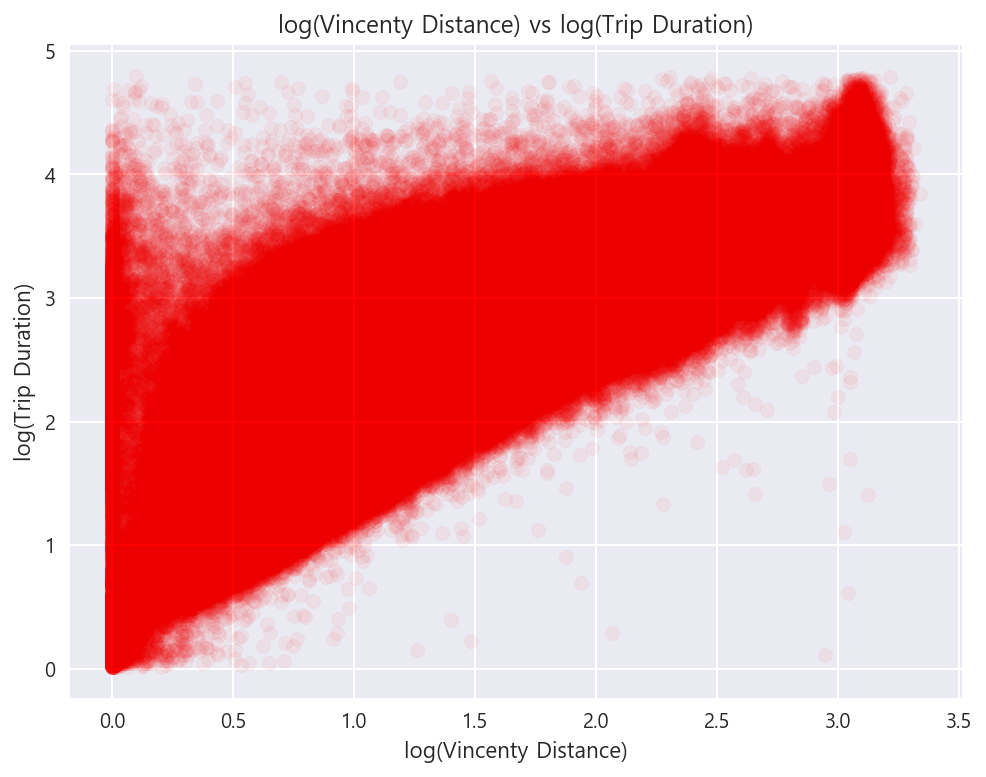

In [52]:
#%% plot scatter of trip duration vs. aerial distance between pickup and dropoff

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

# ax[0].scatter(taxi["vincenty_distance"], taxi["duration_min"], c='r', s=5, alpha=0.01); 
# ax[0].set_xlabel("Vincenty distance (km)"); ax[0].set_ylabel("Trip duration (min)")
# ax[0].set_xlim(taxi["vincenty_distance"].min(), taxi["vincenty_distance"].max())
# ax[0].set_ylim(taxi["duration_min"].min(), taxi["duration_min"].max())
# ax[0].set_title("Trip duration vs Vincenty trip distance")

# ax[1].scatter(taxi["log_vincenty_distance"], taxi["duration_min"], c='r', s=5, alpha=0.01); 
# ax[1].set_xlabel("log(1+Vincenty distance) (km)"); ax[1].set_ylabel("Trip duration (min)")
# ax[1].set_xlim(taxi["log_vincenty_distance"].min(), taxi["log_vincenty_distance"].max())
# ax[1].set_ylim(taxi["duration_min"].min(), taxi["duration_min"].max())
# ax[1].set_title("Trip duration vs Log of vincenty trip distance")

# ax[2].scatter(taxi["log_vincenty_distance"], taxi["log_duration"], c='r', s=5, alpha=0.01); 
# ax[2].set_xlabel("log(1+Vincenty distance) (km)"); ax[2].set_ylabel("log(1+Trip duration) (min)")
# ax[2].set_xlim(taxi["log_vincenty_distance"].min(), taxi["log_vincenty_distance"].max())
# ax[2].set_ylim(taxi["log_duration"].min(), taxi["log_duration"].max())
# ax[2].set_title("Log of Trip duration vs Log of vincenty trip distance")

# plt.figure(figsize=(8, 6))
# plt.scatter(taxi.log_vincenty_distance, taxi.log_duration ,color="r", alpha=0.05)
# plt.ylabel("log(Trip Duration)")
# plt.xlabel("log(Vincenty Distance)")
# plt.title("log(Vincenty Distance) vs log(Trip Duration)");

plt.figure(figsize=(8, 6))
plt.scatter(taxi.log_vincenty_distance, taxi.log_duration ,color="r", alpha=0.05)
plt.ylabel("log(Trip Duration)")
plt.xlabel("log(Vincenty Distance)")
plt.title("log(Vincenty Distance) vs log(Trip Duration)");

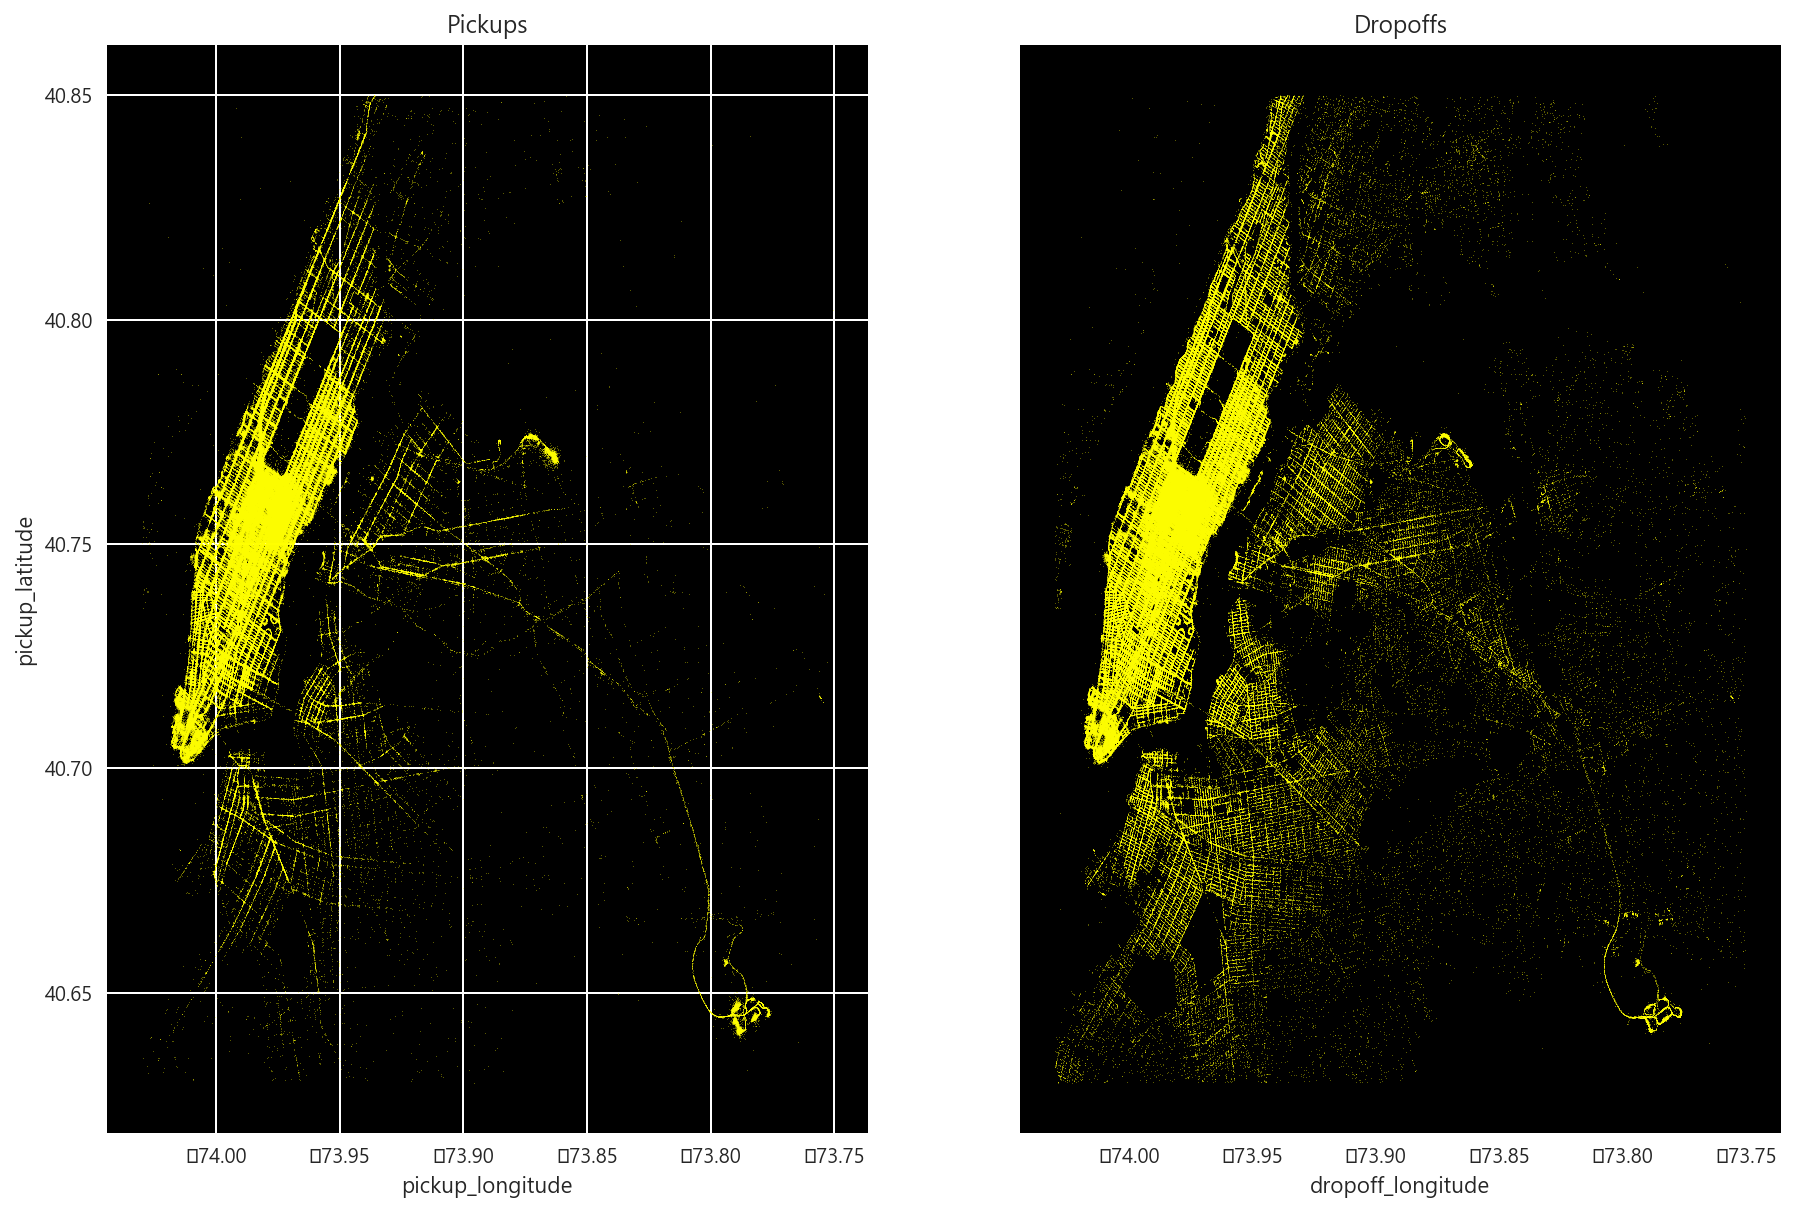

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

taxi.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude",
                color="yellow", 
                s=.02, alpha=.6, subplots=True, ax=ax1)

ax1.set_title("Pickups")
ax1.set_facecolor("black")

taxi.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude",
                color="yellow", grid=False,
                s=.02, alpha=.6, subplots=True, ax=ax2)

ax2.set_title("Dropoffs")
ax2.set_facecolor("black") 

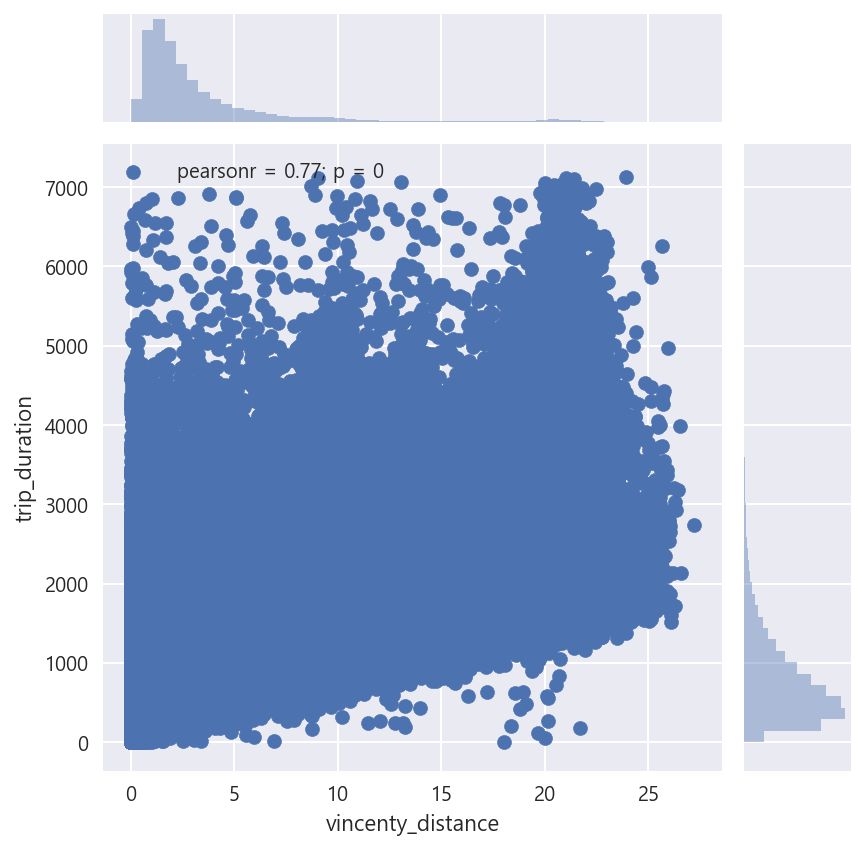

In [54]:
sns.jointplot(x="vincenty_distance", y="trip_duration", data=taxi);

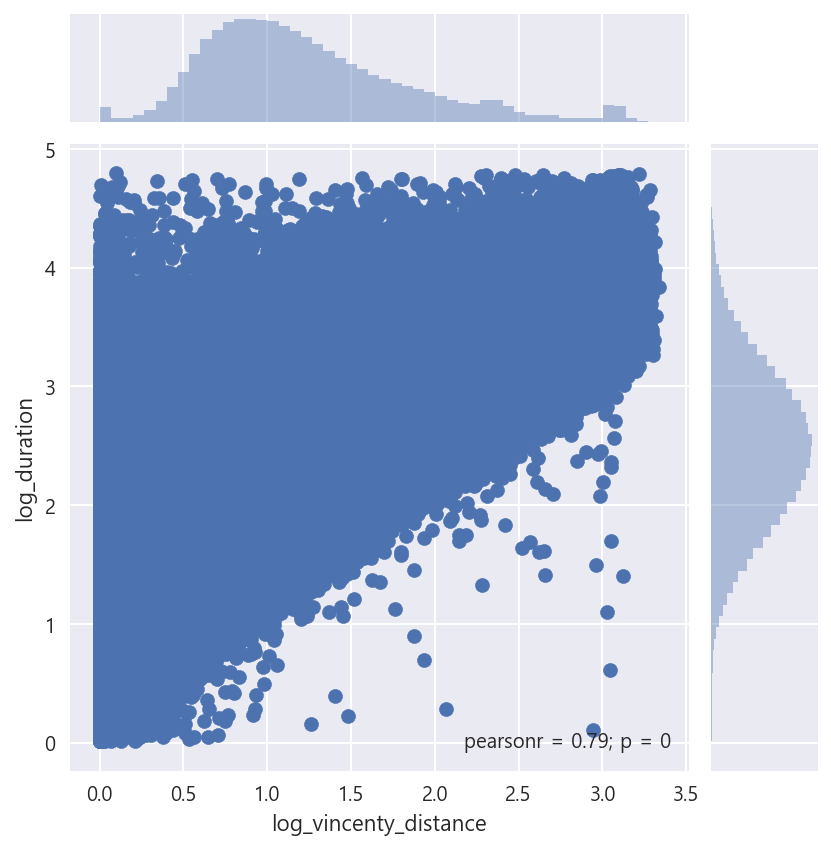

In [55]:
sns.jointplot(x="log_vincenty_distance", y="log_duration", data=taxi);

In [56]:
taxi["pickup_datetime"] = pd.to_datetime(taxi.pickup_datetime)

taxi.loc[:, "pickup_weekday"] = taxi["pickup_datetime"].dt.weekday
taxi.loc[:, "pickup_hour_weekofyear"] = taxi["pickup_datetime"].dt.weekofyear
taxi.loc[:, "pickup_hour"] = taxi["pickup_datetime"].dt.hour
taxi.loc[:, "pickup_minute"] = taxi["pickup_datetime"].dt.minute
taxi.loc[:, "pickup_dt"] = (taxi["pickup_datetime"] - taxi["pickup_datetime"].min()).dt.total_seconds()
taxi.loc[:, "pickup_week_hour"] = taxi["pickup_weekday"] * 24 + taxi["pickup_hour"]

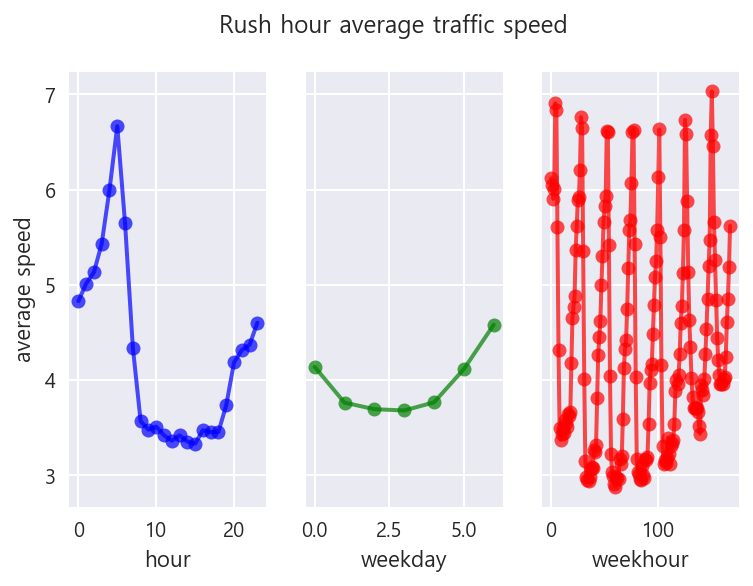

In [57]:
taxi.loc[:, "avg_speed_h"] = 1000 * taxi["vincenty_distance"] / taxi["trip_duration"]
# taxi.loc[:, "avg_speed_m] = 1000 * taxi["distance_dummy_manhattan] / taxi["trip_duration"]

plt.figure(figsize=(15, 7))
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(taxi.groupby("pickup_hour").mean()["avg_speed_h"], 'bo-', lw=2, alpha=0.7)
ax[1].plot(taxi.groupby("pickup_weekday").mean()["avg_speed_h"], 'go-', lw=2, alpha=0.7)
ax[2].plot(taxi.groupby("pickup_week_hour").mean()["avg_speed_h"], 'ro-', lw=2, alpha=0.7)

ax[0].set_xlabel("hour")
ax[1].set_xlabel("weekday")
ax[2].set_xlabel("weekhour")

ax[0].set_ylabel("average speed")
fig.suptitle("Rush hour average traffic speed")
plt.show()

In [58]:
# import gmplot
# gmap = gmplot.GoogleMapPlotter(40.766321, -73.965457, 11)

# gmap.plot(pickup_lat[:100], pickup_lng[:100], 'cornflowerblue', edge_width=10)
# gmap.scatter(pickup_lat[:100], pickup_lng[:100], '#3B0B39', size=40, marker=False)
# gmap.scatter(dropoff_lat[:100], dropoff_lng[:100], 'k', marker=True)

# gmap.draw("mymap.html")

In [59]:
# west, south, east, north = -74.03, 40.63, -73.77, 40.85

# train = train[(train.pickup_latitude> south) & (train.pickup_latitude < north)]
# train = train[(train.dropoff_latitude> south) & (train.dropoff_latitude < north)]
# train = train[(train.pickup_longitude> west) & (train.pickup_longitude < east)]
# train = train[(train.dropoff_longitude> west) & (train.dropoff_longitude < east)]

In [60]:
# def manhattan_distance(x,y):
#     return sum(abs(a-b) for a,b in zip(x,y))

# def euclidean_distance(x,y):
#     return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

# taxi['euclidean_distance'] = taxi.apply(lambda row: euclidean_distance(
#     (row['pickup_latitude'], row['pickup_longitude']),
#     (row['dropoff_latitude'], row['dropoff_longitude'])), axis=1)

# taxi['log_euclidean_distance'] = np.log1p(taxi['euclidean_distance'])

파라미터

- 이동 거리
- 시간대별


- 승/하차 위치 (맨하탄 내부 / 맨하탄 내외부(특히 공항))
- 스피드
- 승객 수

- 가장 큰 영향을 미치는 변수 확인 (아직 안 배움)
- 코드 깔끔히

### 속도와 duration간의 상관관계

In [61]:
taxi_df1.tail()

,passenger_count,trip_duration,count,pickup_datetime,pickup_date,pickup_month,pickup_hour,pickup_weekday
1458639,4,778,1,2016-04-08 13:31:04,2016-04-08,4,13,4
1458640,1,655,1,2016-01-10 07:35:15,2016-01-10,1,7,6
1458641,1,764,1,2016-04-22 06:57:41,2016-04-22,4,6,4
1458642,1,373,1,2016-01-05 15:56:26,2016-01-05,1,15,1
1458643,1,198,1,2016-04-05 14:44:25,2016-04-05,4,14,1


In [67]:
taxi["vincenty_distance"] = vincenty_distance

In [76]:
taxi["avg_speed_km_h"] = taxi["vincenty_distance"] / (taxi["trip_duration"] / 3600)

In [78]:
taxi["avg_speed_km_h"].tail()

1458639     5.678050
1458640    33.231088
1458641    36.855386
1458642    10.544468
1458643    20.611914
Name: avg_speed_km_h, dtype: float64

In [86]:
taxi_hour_sp_du = taxi.loc[:, ["pickup_hour", "avg_speed_km_h", "duration_min"]]
taxi_hour_sp_du = taxi_hour_sp_du.groupby("pickup_hour").mean()
taxi_hour_sp_du.tail()

,avg_speed_km_h,duration_min
pickup_hour,,
19,13.449736,12.999469
20,15.064658,12.597677
21,15.530901,12.686369
22,15.731470,13.156500
23,16.568499,13.239537


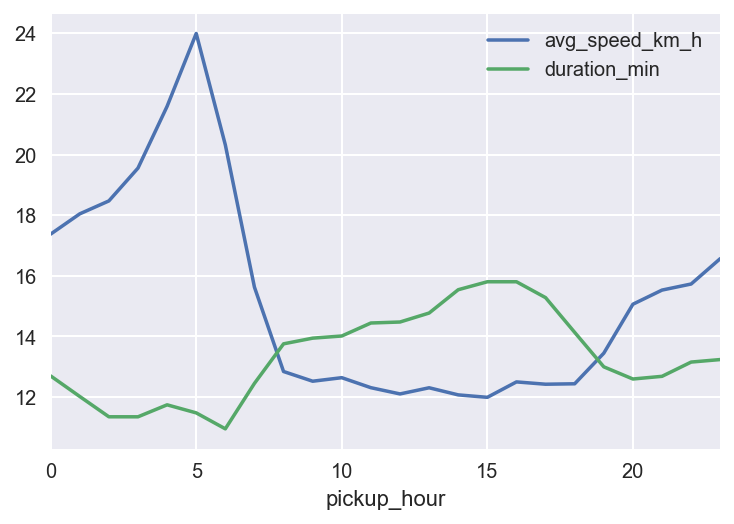

In [87]:
taxi_hour_sp_du.plot()
plt.legend(loc='best')
plt.show()